In [6]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import dates
from tqdm.auto import tqdm
from osgeo import gdal
from glob import glob
import matplotlib
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

odir_top = './'
height_subdir_ir = f'{odir_top}/Height_Out/'
height_subdir_vis = f'{odir_top}/Heightmap/'

In [7]:
# This processes the IR height estimates

# Find files to process
files = glob(height_subdir_ir + '*.tif')

# Make an empty dataframe
data_frame_tir = pd.DataFrame({'dt' : [], 'mh' : [], 'sdp' : [], 'sdm' : [],
                               'p25' : [],'p75' : []})

# Loop over input files
for inf in tqdm(files):
    pos = inf.find('.tif')
    dtstr = inf[pos-15:pos]
    dater = datetime.strptime(dtstr, "%Y%m%d_%H%M%S")
    # Load the data
    ds = gdal.Open(inf)
    heights = np.array(ds.GetRasterBand(1).ReadAsArray()) / 1000.
    
    # Find mean, std-dev, 25 and 75th percentile heights
    mean = np.nanmean(heights)
    stdv1 = np.nanstd(heights)
    p25 = np.nanpercentile(heights, 25)
    p75 = np.nanpercentile(heights, 75)
    # Put all this into the dataframe
    data_frame_tir = data_frame_tir.append(pd.DataFrame({'dt' : [dater], 'mh' : [mean], 'sdp' : [mean + stdv1], 'sdm' : [mean - stdv1], 'p25' : [p25], 'p75' : [p75]}))

  0%|          | 0/52 [00:00<?, ?it/s]

In [8]:
# This processes the VIS height estimates

# Find files to process
files = glob(height_subdir_vis + '*.tif')

# Make an empty dataframe
data_frame_vis = pd.DataFrame({'dt' : [], 'mh' : [], 'sdp' : [], 'sdm' : [],
                               'p95' : [],'p99' : []})

# Loop over input files
for inf in tqdm(files):
    pos = inf.find('.tif')
    dtstr = '20220115_' + inf[pos-4:pos]
    dater = datetime.strptime(dtstr, "%Y%m%d_%H%M")
    # We have to add 6 minutes to get the true time, as Tonga is sligthly South of image centre and the instruments scan N->S
    dater = dater + timedelta(minutes=6)
    # Load the data
    ds = gdal.Open(inf)
    heights = np.array(ds.GetRasterBand(1).ReadAsArray()) / 1000.
    
    # This data isn't filtered for plume only, so as a proxy we remove all tropospheric points (manual analysis shows there aren't any in the plume anyway).
    pts = (heights > 18).nonzero()
    heights=heights[pts]
    
    # Find mean, std-dev, 25 and 75th percentile heights
    mean = np.nanmean(heights)
    stdv1 = np.nanstd(heights)
    p95 = np.nanpercentile(heights, 95)
    p99 = np.nanpercentile(heights, 99)
    # Put all this into the dataframe
    data_frame_vis = data_frame_vis.append(pd.DataFrame({'dt' : [dater], 'mh' : [mean], 'sdp' : [mean + stdv1], 'sdm' : [mean - stdv1], 'p95' : [p95], 'p99' : [p99]}))

  0%|          | 0/17 [00:00<?, ?it/s]

In [9]:
# This lists points computed via the manual VIS parallax analysis
datetimes = [datetime(2022, 1, 15, 4, 15),
             datetime(2022, 1, 15, 4, 16),
             datetime(2022, 1, 15, 4, 17),
             datetime(2022, 1, 15, 4, 25),
             datetime(2022, 1, 15, 4, 26),
             datetime(2022, 1, 15, 4, 27),
             datetime(2022, 1, 15, 4, 36),
             datetime(2022, 1, 15, 4, 37),
             datetime(2022, 1, 15, 4, 46),
             datetime(2022, 1, 15, 4, 47),
             datetime(2022, 1, 15, 4, 54),
             datetime(2022, 1, 15, 4, 55),
             datetime(2022, 1, 15, 4, 56),
             datetime(2022, 1, 15, 4, 57),
             datetime(2022, 1, 15, 4, 58),
             datetime(2022, 1, 15, 5, 6),
             datetime(2022, 1, 15, 5, 26),
             datetime(2022, 1, 15, 5, 27),
             datetime(2022, 1, 15, 5, 45),
             datetime(2022, 1, 15, 5, 46),
             datetime(2022, 1, 15, 5, 47),
             datetime(2022, 1, 15, 6, 6),
             datetime(2022, 1, 15, 6, 7),
             datetime(2022, 1, 15, 6, 25),
             datetime(2022, 1, 15, 6, 26),
             datetime(2022, 1, 15, 6, 27),
             datetime(2022, 1, 15, 6, 36),
             datetime(2022, 1, 15, 6, 37),
            ]
heights = [21.58, 26.05, 27.07, 6.41, 31.78, 39.84, 55.02, 39.42, 46.14,
           52.15, 35.35, 36.28, 33.52, 57.09, 58.33, 44.50, 42.95, 37.70,
           39.22, 37.66, 36.41, 36.64, 35.98, 34.94, 36.18, 34.02, 34.21, 28.59, ]


err = [0.64, 0.53, 0.55, 0.41, 0.62, 0.62, 0.55, 0.57, 0.5, 0.46, 0.57, 0.59, 0.66,
       0.54, 0.55, 0.46, 0.69, 0.51, 0.52, 0.6, 0.61, 0.69, 0.42, 0.6, 0.52, 0.57, 0.58, 0.64, ]


data_frame_plx = pd.DataFrame({'dt' : datetimes, 'height' : heights, 'err': err})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


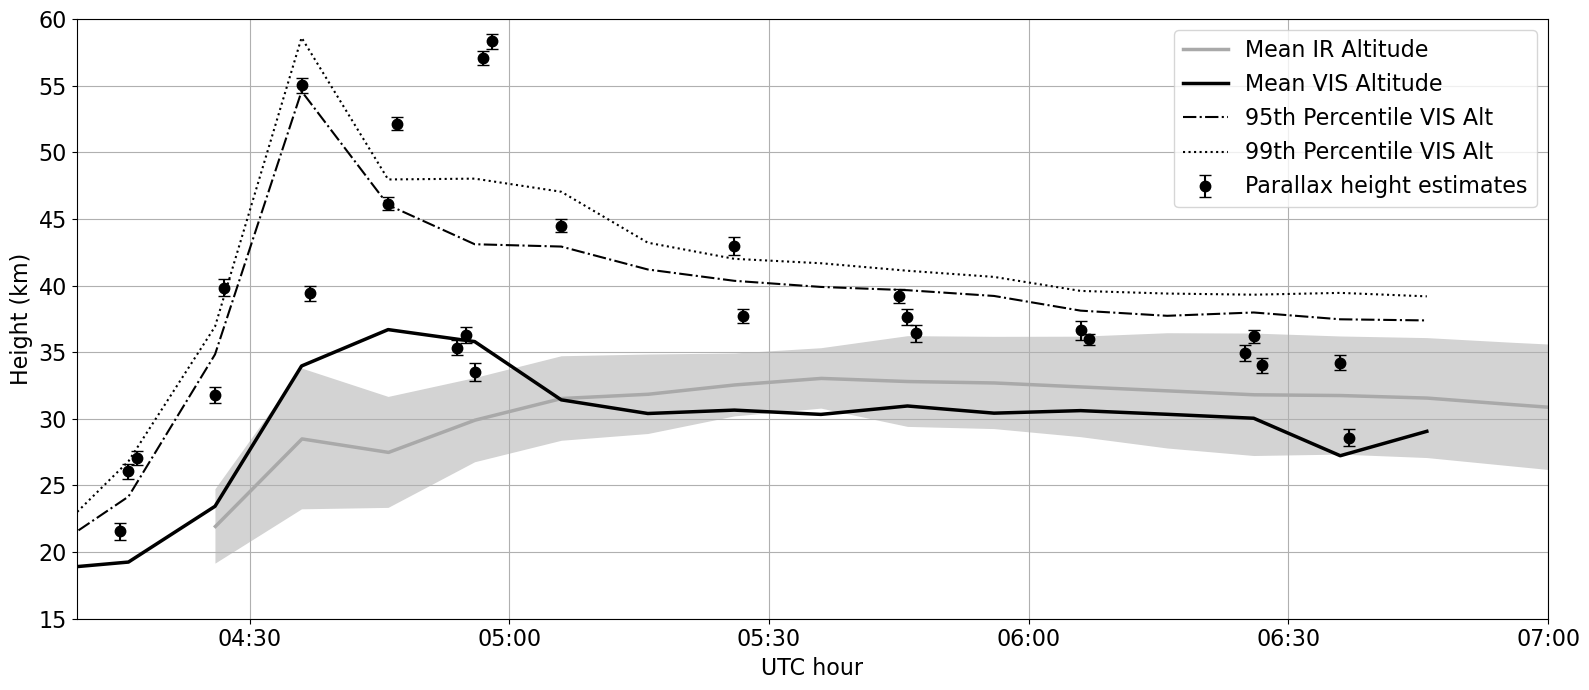

In [14]:
# Set up the plot
fig, ax = plt.subplots(figsize=(16,7))
matplotlib.rcParams.update({'errorbar.capsize': 4})

# The x-axis extent of the plot
st_d = datetime(2022, 1, 15, 4, 10, 0)
en_d = datetime(2022, 1, 15, 7, 0, 0)

# Make some nice tick marks for datetime ranges.
tick_arr = np.array([st_d + timedelta(hours=i) for i in range(0, 14, 2)])
hfmt = dates.DateFormatter('%H:%M')
plt.grid()
ax.set_xlim([st_d, en_d])
ax.set_ylim([15, 60])
ax.xaxis.set_major_formatter(hfmt)

# Plot the mean value and a shaded standard deviation
ax.plot(data_frame_tir['dt'], data_frame_tir['mh'], c='darkgrey', linewidth=2.5, label='Mean IR Altitude')
ax.plot(data_frame_vis['dt'], data_frame_vis['mh'], c='black', linewidth=2.5, label='Mean VIS Altitude')
ax.fill_between(data_frame_tir['dt'], data_frame_tir['sdp'], data_frame_tir['sdm'], facecolor='lightgrey', interpolate=True)

# Plot the 95th and 99th percentiles
ax.plot(data_frame_vis['dt'], data_frame_vis['p95'], c='black', linewidth=1.5, label='95th Percentile VIS Alt', linestyle='-.')
ax.plot(data_frame_vis['dt'], data_frame_vis['p99'], c='black', linewidth=1.5, label='99th Percentile VIS Alt', linestyle=':')

plt.errorbar(data_frame_plx['dt'], data_frame_plx['height'], yerr=data_frame_plx['err'], fmt=".", c='black', markersize='15', label='Parallax height estimates')

# finish setting up the plot
ax.set_xlabel('UTC hour', fontsize=16)
ax.set_ylabel('Height (km)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.legend(prop={'size': 16})
plt.tight_layout()
# Save everything
plt.savefig('./Figures/Figure_3.png', facecolor='white')
plt.savefig('./Figures/Figure_3.eps', format='eps', facecolor='white')